In [ ]:
!pip install torchmetrics lightning torch-fidelity torchmetrics[image]

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, ConcatDataset,  Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.optim import Adam

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, DeviceStatsMonitor, EarlyStopping

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

# Data and model preparation

## Download Data

In [ ]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset_divided = random_split(train_data, [0.334, 0.333, 0.333])
test_dataset_divided = random_split(test_data, [0.334, 0.333, 0.333])

In [ ]:
class ImageOnlyDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [ ]:
fraction_of_real_data = {"phase_0": [1],
                        "phase_1": [1, 0.8, 0.6, 0.4, 0.2, 0],
                        "phase_2": [1, 0.8, 0.6, 0.4, 0.2, 0]}
train_real_dataset_dict = defaultdict(list)
test_real_dataset_dict = defaultdict()

for i in range(3):
    for fraction in tqdm(fraction_of_real_data[f"phase_{i}"]):
        real_dataset, _ = random_split(train_dataset_divided[i], [fraction, 1 - fraction])
        image_only_real_dataset = ImageOnlyDataset([real_dataset[j][0] for j in range(len(real_dataset))])
        train_real_dataset_dict[f"phase_{i}"].append(image_only_real_dataset)

    test_dataset = test_dataset_divided[i]
    test_real_dataset_dict[f"phase_{i}"] = ImageOnlyDataset([test_dataset[j][0] for j in range(len(test_dataset))])

## Model Creation

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(32*7*7, latent_dim)
        self.fc_std = nn.Linear(32*7*7, latent_dim)

    def forward(self, x):
        mu, log_var = self.conv_net(x).chunk(2, dim=1)
        return self.fc_mu(mu), self.fc_std(log_var)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64*7*7)
        self.conv_net = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        return self.conv_net(x)

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def sample_images(self, num_samples=16):
        self.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim)
            samples = self.decoder(z)
        return samples

In [ ]:
class VAELightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.example_input_array = torch.rand(1, 1, 28, 28)  # for model summary

    def forward(self, x):
        return self.model(x)

    def loss_function(self, recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return BCE + KLD, BCE, KLD

    def training_step(self, batch, batch_idx):
        x = batch
        recon_x, mu, log_var = self(x)
        loss, BCE, KLD = self.loss_function(recon_x, x, mu, log_var)

        self.log('train_loss', loss)
        self.log('train_recon', BCE)
        self.log('train_KL', KLD)

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch
        recon_x, mu, log_var = self(x)
        loss, BCE, KLD = self.loss_function(recon_x, x, mu, log_var)

        self.log('val_loss', loss)
        self.log('val_recon', BCE)
        self.log('val_KL', KLD)

        if batch_idx == 0:
            self._visualize_reconstructions(x[:8], recon_x[:8])

        return loss

    def _visualize_reconstructions(self, original, reconstructed):
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(original[i].squeeze().cpu().detach().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(reconstructed[i].squeeze().cpu().detach().numpy(), cmap='gray')
            axes[1, i].axis('off')
        plt.tight_layout()

        try:
            self.logger.experiment.add_figure('reconstructions', fig, self.global_step)
        except:
            plt.show()
        plt.close()

    def configure_optimizers(self):
        return Adam(self.model.parameters(), lr=self.lr)

## Utility Functions

In [ ]:
def plot_samples(samples, ncol=20):
    """Plot generated samples in a grid"""
    grid = make_grid(samples, nrow=ncol, padding=2)
    plt.figure(figsize=(20, 20))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:
def calculate_vae_metrics(model, dataloader, device='cpu'):
    model.eval()
    model = model.to(device)
    fid = FrechetInceptionDistance(feature=64).to(device)

    total_mse = 0.0
    total_kl = 0.0
    num_samples = 0

    with torch.no_grad():
        for x in tqdm(dataloader, desc='Calculating metrics'):
            x = x.to(device)
            batch_size = x.size(0)

            recon_x, mu, logvar = model(x)

            mse = F.mse_loss(recon_x, x, reduction='sum')
            total_mse += mse.item()

            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            total_kl += kl.item()

            # real_images = (x * 255).byte().repeat(1, 3, 1, 1)
            # fake_images = (recon_x * 255).byte().repeat(1, 3, 1, 1)
            # fid.update(real_images, real=True)
            # fid.update(fake_images, real=False)

            num_samples += batch_size

    metrics = {
        'reconstruction_mse': total_mse / num_samples,
        'kl_divergence': total_kl / num_samples,
        # 'fid_score': fid.compute().item()
    }

    model = model.to("cpu")

    return metrics

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=<...>

# Phase 0

Here we train the model only on real data

In [ ]:
train_loader_0 = DataLoader(train_real_dataset_dict["phase_0"][0], batch_size=batch_size, shuffle=True)
test_loader_0 = DataLoader(test_real_dataset_dict["phase_0"], batch_size=batch_size, shuffle=False)

In [ ]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="<...>", version="phase_0_real_data")

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min')
device_stats = DeviceStatsMonitor()
early_stopping = EarlyStopping('val_loss')

model_phase_0 = VAE(latent_dim=20)
module_phase_0 = VAELightningModule(model_phase_0, lr=1e-3)

In [ ]:
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices='auto',
    logger=tb_logger,
    callbacks=[checkpoint_callback,
               early_stopping,
               device_stats]
)

trainer.fit(module_phase_0, train_loader_0, test_loader_0)

In [ ]:
metrics = defaultdict(list)

metrics_phase_0 = calculate_vae_metrics(model_phase_0, test_loader_0, device=device)
metrics["phase_0"].append(metrics_phase_0)

In [ ]:
samples = model_phase_0.sample_images(num_samples=20)
plot_samples(samples)

# Phase 1

Here we mix real and synthetic data (from Phase 0) in different proprotions to train new VAE models on them.

In [ ]:
def prepare_dataloaders(model_to_generate_data, phase, i):
    train_dataset = train_real_dataset_dict[phase][i]
    fraction = fraction_of_real_data[phase][i]

    n_images = int(len(train_dataset_divided[int(phase.split("_")[-1])]) * (1 - fraction))
    samples = model_to_generate_data.sample_images(n_images)

    train_dataset = ConcatDataset([train_dataset, ImageOnlyDataset(samples)])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_real_dataset_dict[phase], batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(train_loader, test_loader, max_epochs=50, version="0"):
    tb_logger = pl_loggers.TensorBoardLogger(save_dir="<...>", version=version)

    checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min')
    device_stats = DeviceStatsMonitor()
    early_stopping = EarlyStopping('val_loss')

    model = VAE(latent_dim=20)
    module = VAELightningModule(model, lr=1e-3)

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        devices='auto',
        logger=tb_logger,
        callbacks=[checkpoint_callback,
                early_stopping,
                device_stats]
    )

    trainer.fit(module, train_loader, test_loader)
    return model

def phase_of_training(phase, model_to_generate_data, version, max_epochs=20):
    n_models = len(fraction_of_real_data[phase])

    for i in range(n_models):
        train_loader, test_loader = prepare_dataloaders(model_to_generate_data, phase, i)

        model = train_model(train_loader, test_loader, max_epochs=max_epochs, version=version + f"_model_{i}")

        metrics_ = calculate_vae_metrics(model, test_loader, device=device)
        metrics[phase].append(metrics_)

In [ ]:
phase_of_training("phase_1", model_phase_0, "phase_1_generator_0", max_epochs=50)

In [ ]:
logs_dir = "<...>"

for j in range(6):
  vae_model = VAE()

  checkpoint_path = logs_dir + f'phase_1_generator_0_model_{j}/checkpoints/'
  checkpoint_path += os.listdir(checkpoint_path)[0]

  loaded_model = VAELightningModule.load_from_checkpoint(
      checkpoint_path,
      model=vae_model
  )

  model_j_phase_1 = loaded_model.model.cpu()
  model_j_phase_1.eval()

  samples = model_j_phase_1.sample_images(20)
  fraction = fraction_of_real_data["phase_1"][j]
  print(f"Model {j} from the Phase 1 with real/synthetic data = {fraction}/{round(1 - fraction, 1)}")
  plot_samples(samples)

## Phase 2  

Here we also train models on the mixture of the real and synthesized data, but this time image generators are gonna be from the Phase 1. We are gonna learn 6  new models from 3 model of Phase 1: model_0 (trained only on real data, hase the best reconstruction loss), model_2 (trained on 60% of real data and 40% of synthesized one, has the best kl loss) and model_5 (trained fully on synthetic data, has the worst both reconstruction and kl losses)

In [ ]:
logs_dir = "<...>"

model_numbers = [0, 2, 5]

for j in model_numbers:
  vae_model = VAE()

  checkpoint_path = logs_dir + f'phase_1_generator_0_model_{j}/checkpoints/'
  checkpoint_path += os.listdir(checkpoint_path)[0]
  loaded_model = VAELightningModule.load_from_checkpoint(
      checkpoint_path,
      model=vae_model
  )

  model_j_phase_1 = loaded_model.model.cpu()
  model_j_phase_1.eval()

  phase_of_training("phase_2", model_j_phase_1, f"phase_2_generator_{j}", max_epochs=50)

In [ ]:
for m in [0, 2, 5]:
  for j in range(6):
    vae_model = VAE()

    checkpoint_path = logs_dir + f'phase_2_generator_{m}_model_{j}/checkpoints/'
    checkpoint_path += os.listdir(checkpoint_path)[0]

    loaded_model = VAELightningModule.load_from_checkpoint(
        checkpoint_path,
        model=vae_model
    )

    model_j_phase_2 = loaded_model.model.cpu()
    model_j_phase_2.eval()

    samples = model_j_phase_2.sample_images(20)
    fraction = fraction_of_real_data["phase_2"][j]
    print(f"Model {j} from the Phase 2 with real/synthetic data = {fraction}/{round(1 - fraction, 1)}, trained on the generator number {m} from the Phase 1")
    plot_samples(samples)

  print("\n\n")

# Visualize the Results

In [ ]:
def plot_single_tree(metrics_dict, metric_name, ax):
    G = nx.Graph()
    fractions = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]

    all_values = [metrics_dict['phase_0'][0][metric_name]]
    all_values.extend([x[metric_name] for x in metrics_dict['phase_1']])
    all_values.extend([x[metric_name] for x in metrics_dict['phase_2']])

    norm = mcolors.Normalize(vmin=min(all_values), vmax=max(all_values))
    cmap = plt.cm.RdYlGn_r

    phase0_value = metrics_dict['phase_0'][0][metric_name]
    G.add_node("phase_0",
               color=cmap(norm(phase0_value)),
               value=phase0_value,
               label="1$^r$/0$^s$")

    for i in range(6):
        node_name = f"phase_1_{i}"
        value = metrics_dict['phase_1'][i][metric_name]
        frac = fractions[i]
        label = f"{frac:.1f}$^r$/{1-frac:.1f}$^s$" if frac != 1.0 else "1$^r$/0$^s$"
        G.add_node(node_name,
                  color=cmap(norm(value)),
                  value=value,
                  label=label)
        G.add_edge("phase_0", node_name)

    connections = [0, 2, 5]
    for group_idx, phase1_node in enumerate(connections):
        for i in range(6):
            phase2_idx = group_idx * 6 + i
            node_name = f"phase_2_{phase2_idx}"
            value = metrics_dict['phase_2'][phase2_idx][metric_name]
            frac = fractions[i]
            label = f"{frac:.1f}$^r$/{1-frac:.1f}$^s$" if frac != 1.0 else "1$^r$/0$^s$"
            G.add_node(node_name,
                      color=cmap(norm(value)),
                      value=value,
                      label=label)
            G.add_edge(f"phase_1_{phase1_node}", node_name)

    pos = {
        "phase_0": (0, 0),
        **{f"phase_1_{i}": (1, i - 2.5) for i in range(6)},
        **{f"phase_2_{i}": (2, (i//6)*6 + (i%6) - 8.5) for i in range(18)}
    }

    nx.draw(G, pos, ax=ax,
            node_size=1800,
            node_color=[G.nodes[n]['color'] for n in G.nodes],
            with_labels=True,
            labels={n: G.nodes[n]['label'] for n in G.nodes},
            font_size=9,
            font_weight='bold',
            edge_color='gray',
            width=1.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label=metric_name.replace('_', ' ').title())
    cbar.set_label('')

    ax.axis('off')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 17))

plot_single_tree(metrics, 'reconstruction_mse', ax1)
ax1.set_title('Reconstruction MSE', pad=20, fontsize=20)

plot_single_tree(metrics, 'kl_divergence', ax2)
ax2.set_title('KL Divergence', pad=20, fontsize=20)

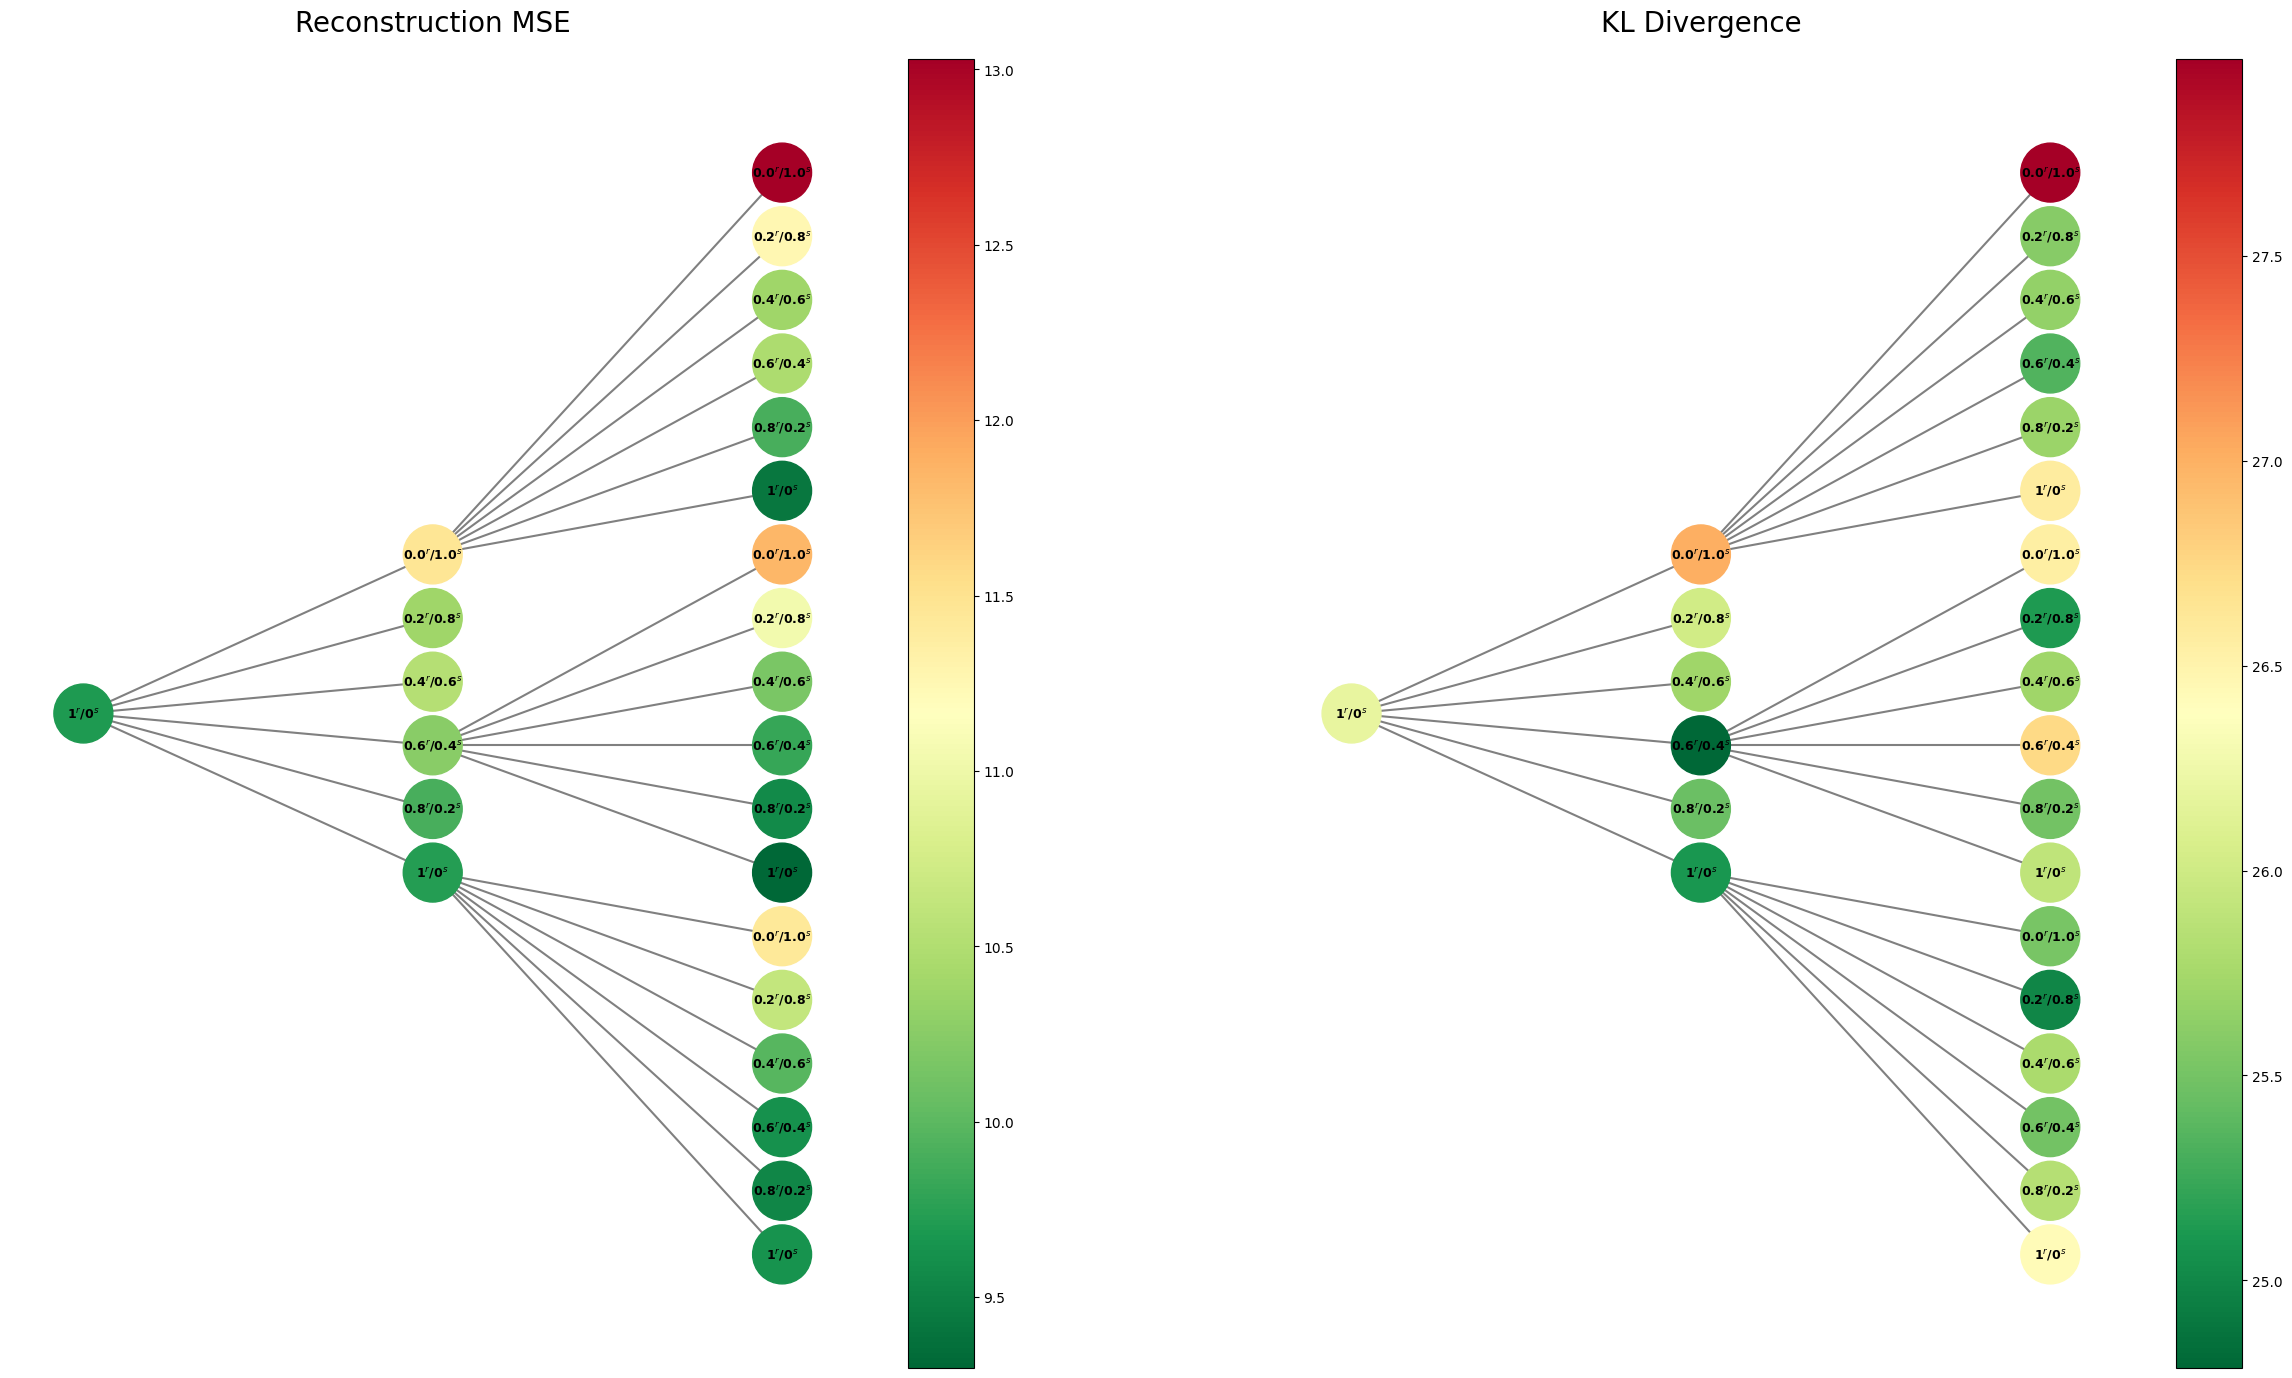